# Lesson 1 - Discrete Methods #

### First Part: Tree ###

# Introduction #

First of all we import numpy and matplotlib under the names np and plt,
respectively, as this is very common in the Python scientific computing
community and a good programming habit.

In [1]:
%matplotlib inline

import math
import scipy
import numpy             as np
import pandas            as pd
import scipy.stats       as ss
import matplotlib
import pylab

from pylab import *
from matplotlib import pyplot as pl

# local module
from gdl_finance.analytic import BlackScholes
from gdl_finance.trees    import binomial_tree

Let's start with a quick review of the problem of early exercise. First of all take a look at a very well known plot, the graph of the european option price from the Black and Scholes model...

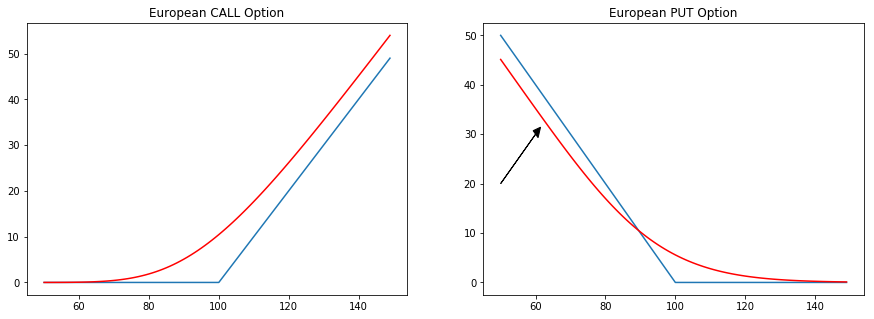

In [2]:
K     = 100.0   # strike price
T     =   1     # time-to-maturity
r     =   0.05  # short rate
sigma =   0.20  # volatility
delta =   0.0   # dividend yield

S      = np.arange(50, 150, 1.0)
C      = BlackScholes(1, S, K, r, delta, sigma, T)
P      = BlackScholes(-1, S, K, r, delta, sigma, T)
payC   = np.maximum(S-K,0)
payP   = np.maximum(K-S,0)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('European CALL Option')
plt.plot(S,payC)
plt.plot(S,C,color='r')

plt.subplot(122)
plt.title('European PUT Option')
plt.arrow(50,20,10,10,head_width=2, head_length=2, fc='k', ec='k')
plt.plot(S,payP)
plt.plot(S,P, color='r')


This figure show that before expiry there is a large range of asset values $S$ for which the value of a European Put Option is less than its intrinsic value (the payoff function). Suppose that $S$ lies in this range, so that $P(S,T) < max(K-S,0)$, and consider the effect of exercising the option. There is an obvious arbitrage opportunity: **we can buy the asset in the market for $S$ and, at the same time we buy the option for $P$**.If we immediately exercise the option by selling the asset for K we thereby make a risk-free profit because $K-S > P \Rightarrow K-S-P > 0$. Of course such an opportunity would not last long before the value of the option was pushed up by the demand of arbitrages. We conclude that when early exercise is permitted we must impose the constraint

$$
P(S,t) \ge max(K-S,0)
$$

American and European Put Options must therefore have different values.

A second example of an American option whose differes from that of its European equivalent is a call option on a dividend-paying asset. 

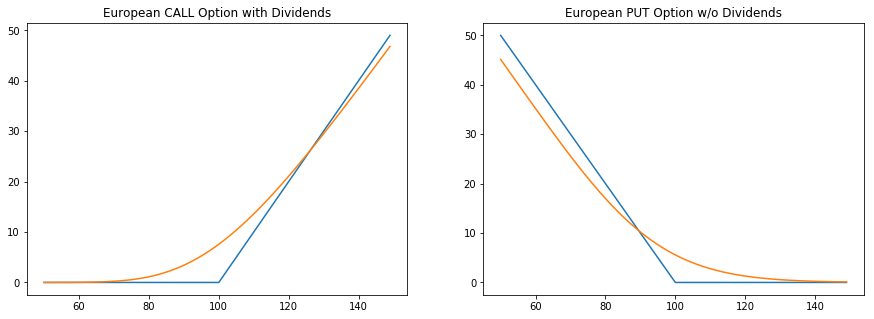

In [3]:
delta  =   0.05  # dividend yield
r      =   0.05

S      = np.arange(50, 150, 1.0)
C      = BlackScholes(1, S, K, r, delta, sigma, T)
P      = BlackScholes(-1, S, K, r, 0.0, sigma, T)
payC   = np.maximum(S-K,0)
payP   = np.maximum(K-S,0)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('European CALL Option with Dividends')
plt.plot(S,payC)
plt.plot(S,C)

plt.subplot(122)
plt.title('European PUT Option w/o Dividends')
plt.plot(S,payP)
plt.plot(S,P)


As we can see an arbitrage argument as above can be used to show that the American version of this option must also be more valuable than the European version since it must satisfy the constraint

$$
C(S,t) \ge max(S-K,0)
$$



## The Problem of Early Exercise ##

### Optimal Stopping Time ###

The valuation of early-exercisable options, or American style options, is a task of major importance in derivatives pricing because these types of instruments are found in all major financial markets including equity, commodity, foreign exchange, credit and convertible. Even though some authors presented analytical approximations for certain early-exercisable options, exact closed-form solutions are in general not existent for these instruments. 

Let's formulate exactly the problem of the early exercise in order to understand what is the main difficulty in finding the solution of the evaluation problem.

American type derivative securities contain implicit or explicit options which **can be exercised before expiration date if desired**.

Consider an American option written on a stock. The option can be exercised at any time between the present date $t=0$ and time to maturity $t=T$. **The holder will exercise this option if he thinks that it is better to do so, rather than waiting until expiration**. The right of early exercise may have some additional value and pricing methods for American style securities must take this into account.

Let $\tau \in [0,T]$ represents the early exercise date. Given the information set at time $t$, $I_t$ , we will be able to tell whether the option has already been exercised or not. The problem is that with American type securities $\tau$ is in general random. 

The option price may be described by a generic function $F(S_t, t)$. In the most simple framework, the underlying stock price is assumed to behaves in continuous time as a geometric Brownian motion

\begin{equation}
dS = \mu S \> dt + \sigma S \> dz
\end{equation}

and, as we already known, the price of the derivative can be expressed using the risk neutral $Q$, **but this time the option holder does not have to wait until expiration $T$ to exercise the option. He will exercise the option as soon as it is more profitable to do so**. If the option is exercised at a generic time $\tau$ its value at $t$ would be

\begin{equation}
F(S_t, t) = E^Q_t \left[ e^{-r(\tau-t)} max\left(S_\tau - K,0 \right) \right]
\end{equation}

Therefore the pricing problem at time $t=0$ becomes the calculation of

\begin{equation}
F(S_0, 0) = \sup\limits_{\tau \in [0, T]} 
\left\{
E^Q_0 \left[ e^{-r\tau} max\left(S_\tau - K,0 \right) \right]
\right\}
\end{equation}

This supremum is achieved by an optimal stopping time $\tau^\star$ that has the form

\begin{equation}
\tau^\star = \inf \left\{ t \ge 0: S_t \ge b^\star_t \right\}
\end{equation}

for some optimal exercise boundary $b^\star$.

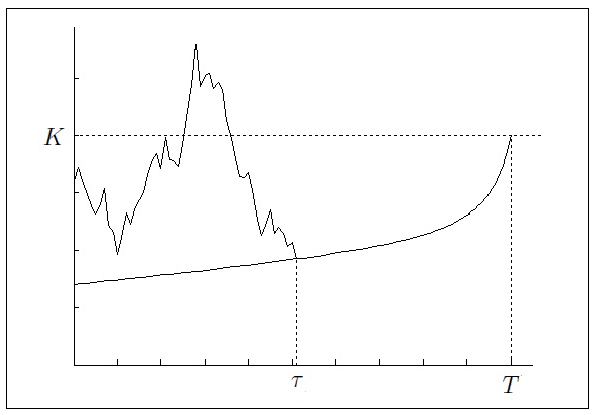
**Figure 1**: *The optimal exercise boundary and a stock price trajectory and its corresponding $\tau^\star$, the ﬁrst time it goes below $b^\star$*


**Since the asset price at which the early exercise is optimal isn’t known in advance it has to be found as part of the solution problem**.

For this reason an analytic solution to the problem does not exist except for very special cases. Thus the general practice is to implement numerical procedures to generate accurate estimates of the option price

### Stopping Rules ###


Any *stopping time* $\tau$ results in a value

\begin{equation}
V_0^\tau \left( S_0 \right) = E \left[ h_\tau \left( S_\tau \right) \right]
\end{equation}

where $h_t \left( S_t \right)$ is the option payoff.  On the other hand, if we assign any values $\hat V_i (s)$ to the option on each of the time states (with the final condition that $\hat V_T = h_T(S_T)$), we can make a stopping rule as

\begin{equation}
\tau^\star = \min \left\{ i \in \{1,\dots,n\}: 
h_i(S_i) \ge \hat V_i(S_i) \right\}
\end{equation}

**In other words we exercise the option when the payoﬀ from exercising, $h_i(S_i)$ is higher than what we expect to gain if we continue (continuation values)**. The continuation values are the values of holding the option rather than exercising it. The problem is, as before, that in general we do not known in advance what is the continuation values. As we have already said this is, in general, part of the problem we are dealing with. 

### Strengths and weaknesses of different computational methods ###

The primary methods for pricing such derivatives are binomial trees, finite difference and LS-Montecarlo methods. 

The tree method discretizes the solution space although the discretization is chosen to represent the distribution of the underlying stock price process, instead of the entire solution space. 

The finite difference method estimates the solution of a partial differential equation (PDE) by discretizing the solution space into a grid and then solving the PDE by recursion. 

The **shortcoming** is that **these techniques become computationally prohibitive when they are generalized to handle multiple dimensions**, with computation time typically increasing exponentially with the number of state variables.

Usually both these procedures start from the maturity date and then go **backward** toward time zero. In doing this they construct a hedging portfolio that perfectly replicates the payoffs in the future and finally set the option price equal to the value of the hedging portfolio at time zero. Working backwards in time starting from the expiration date, the optimal exercise strategy and the price of the options can be easily estimated, so a **strength of tree and finite difference methods is that they can handle easily the early exercise feature of american products**.

The use of simulation methods in security pricing may offer a number of decisive advantages. First of all **the convergence rate of the Monte Carlo approach is independent of the number of state variables** which makes the method computationally appealing for solving high-dimensional problems. Moreover the method is flexible with respect to the evolution of the state variables offering the opportunity to price derivative securities with more complex process dynamics. At the end path dependency features can easily be incorporated in a Monte Carlo pricing framework. On the other hand, **the major drawback of simulation procedures is the difficulty in dealing with the early exercise feature of American options**. 

In particular, standard simulation procedures are **forward** algorithms, that is, the trajectories of the state variables are simulated forward in time. Then, given a pre-specified exercise policy, a path price is determined for each trajectory. The average of path prices gives an unbiased estimate of the derivative security price.  

### Forward Algorithm ###

The approach is easy and intuitive: We simulate $n$ random trajectories using time discretization. Then we compute the value of the option in each trajectory and get an average on all of them, leading to an estimated value of the European option.

In [4]:
#np.random.seed(150000)
# Model Parameters
S0    =  70.0   # initial stock level
K     = 100.0   # strike price
T     =   1.0   # time-to-maturity
r     =   0.01  # short rate
sigma =   0.20  # volatility
delta =   0.0   # dividend yield

# Simulation Parameters
b = 10000    # number of paths
M = 100      # number of points for each path
dt = float(T) / float(M)
df = math.exp(-r * dt)
#
# Random numbers generations. We use the function 'randn' which returns 
# a sample (or samples) from the "standard normal" distribution.
# If positive, int_like or int-convertible arguments are provided,
# 'randn' generates an array of shape (d0, d1, ..., dn), filled
# with random floats sampled from a univariate "normal" (Gaussian)
# distribution of mean 0 and variance 1
#
z1  = np.random.randn(M + 1, b)
#
# Stock Price Paths. The function 'cumsum' returns the cumulative sum 
# of the elements along a given axis, in this case we want to sum along
# the time axis (axis=0). Note that since z1 is a 2D-array also S is
# a 2D-array
#
S     = S0 * np.exp(np.cumsum((r - 0.5 * sigma ** 2) * dt 
       + sigma * math.sqrt(dt) * z1, axis=0))
S[0]  = S0

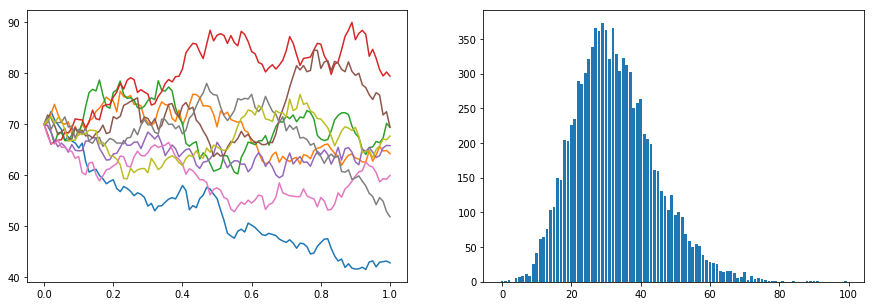

In [5]:
# plotting the first n paths
t = np.linspace(0, T, M+1)
paths = S[:,0:9]
#
# plotting expiry price distribution. Note that the S matrix is build 
# with the first index running on the time slice and the second index
# running on the number of simulated path. Remember that Python programming 
# language supports negative indexing of arrays, something which is not 
# available in arrays in most other programming languages. This means that 
# the index value of -1 gives the last element, and -2 gives the second 
# last element of an array. The negative indexing starts from where the 
# array ends. So in this case we are selecting all the simulated value 
# (second index = ':') of the last simulated time (first index = '-1').
#
expiry = S[-1,:]
hist = np.histogram(expiry, 100)
index = np.arange(100)

pl.figure(figsize=(15,5))
pl.subplot(121)

strike = np.array([K for n in range(0,M+1)])
#pl.plot(t, strike, color='r', dashes=[6,2], linewidth=3.0)
pl.plot(t, paths)

pl.subplot(122)
pl.bar(index, hist[0])

pl.show()

By contrast, as we have seen, pricing methods for American style derivatives are generally backward algorithms. That is to say, the optimal exercise strategy at maturity is determined and proceeding backward in time dynamic programming determines the optimal exercise strategy and the corresponding price at previous dates. 

**The problem of using simulation methods to price American options stems from the difficulty in applying forward-based procedures to problems that necessitate a backward procedure to be solved**.

All the numerical methods we are dealing with, use time discretization for pricing American put options. So in fact they consider that exercising the option is possible only on a ﬁnite number of times. These kind of options are called Bermudan. So we actually are discussing methods for Bermudan put options. Of course we can recover the case of an American Option choosing time intervals small enough.

## Binomial Tree for Option Pricing ##

### What is a binomial tree ###

The binomial pricing method is a simple and computationally fast method for pricing
vanilla options. 

With this method, you create **a tree of possible price outcomes of the underlying asset**. To do this you start with the current spot price of the underlying asset. From this, you create two branches, one with the expected price in the next period in an upstate and the other for the expected price in a downstate. These states are calculated by dividing the life of the option into a large numer of intervals $n$ of equal length $\Delta t$. 

At each period, the stock may move from the initial value $S$ to either up ($Su$) with probability p or down ($Sd$) with probability $q=1-p$. The interest rate is constant and is denoted by $r$. From each of these branches you will create two more branches by the same process. This process is repeated until the options expiry is reached, creating a price tree.

Let's start considering only one period to expiration, an hypothetical call option written on the asset will have at expiration the payoffs $c_u = \max[0, S_0u-K]$ if the stock price goes to $S_0u$ and $c_d= \max[0, S_0d-K]$ if the stocks decreases to $S_0d$.

If a portfolio can be constructed with a long position of $\Delta$ shares of the stock and a short position in the option, the value of our portfolio in the two states will be:

$$\Delta S_0u - c_u$$ 
$$\Delta S_0d - c_d$$

It is easy to find that if we choose $\Delta$ as 

\begin{equation}
  \Delta = \frac{C_u - C_d}{(u-d)S_0} \sim \frac{\partial C}{\partial S}
\end{equation}

our portfolio will have the same value in both states so it will be a *risk free* portfolio.

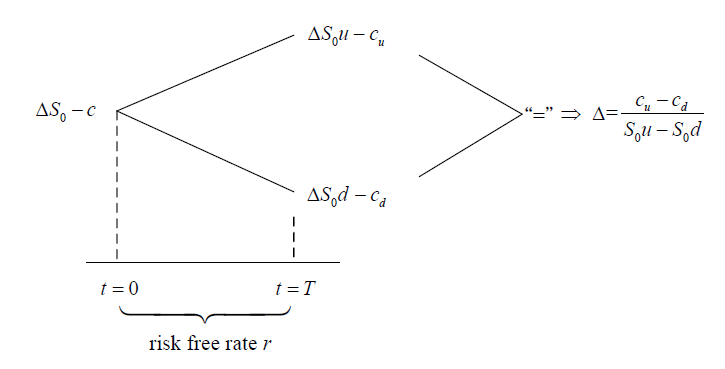

To preclude the existence of arbitrage opportunities in the market the yield of our portfolio must be the risk free rate, so considering a unit interval we have

$$
P_T = e^{rT}P_0
$$

\begin{align}
&\frac{P_T}{P_0} = \frac{S_0 \Delta \cdot  u -c_u}{S_0 \Delta  - C} \> = e^{rT} \Rightarrow \notag\\
\Rightarrow C &= \frac{S_0 \Delta \cdot e^{rT} + c_u - u S_0 \Delta }{e^{rT}} \notag\\\
              &= \frac{S_0\Delta\cdot  (e^{rT}-u) + c_u}{e^{rT}}
\end{align}

and, using the value of $\Delta$ 

\begin{align}
C &= \frac{\frac{c_u-c_d}{u-d}(e^{rT}-u)+c_u}{e^{rT}}  \notag\\
  &= \frac{c_ue^{rT}-c_uu-c_de^{rT}+c_du+c_uu-c_ud}{e^{rT}(u-d}  \notag\\
  &= e^{-rT} \frac{c_u(e^{rT}-d) + c_d(u-e^{rT})}{(u-d)} \notag\\
  &= e^{-rT} \left[ c_u \frac{e^{rT}-d}{u-d} + c_d \frac{u-e^{rT}}{u-d} \right] \notag\\
  &= e^{-rT}\Bigl[ p\cdot c_u + (1-p) \cdot c_d \Bigr] 
\end{align}

where

\begin{equation}
  p \equiv \frac{e^{rT}-d}{u-d} \quad \quad 1-p \equiv \frac{u-e^{rT}}{u-d}
\end{equation}

$p$ if we assume $d \le r \le d$, $p$ is always greater than zero and less than one showing the basic properties of a probability measure.

### The Cox, Ross and Rubinstein Tree ###

With respect to the definition of $p$, $u$ and $d$ an important assumption about the behavior of the stochastic process of the underlying stock has to be done. In the following we'll follow the framework set up by Cox, Ross and Rubinstein. 

Let's assume that the stochastic process is continuous as $n \rightarrow \infty$. The parameters $p$, $u$ and $d$ must be chosen in a way to determine the right values of the stock expected return and variance at the end of each interval $\Delta t$. **Given the assumption of risk neutrality the one period expected return of the stock is equal to the risk free rate**

$$r \Delta t$$ 

and the expected future stock price is

\begin{equation}
        Se^{r\Delta t} =pSu + (1-p)Sd \Rightarrow  E_\pi \left[r\Delta t \right] =pu + (1-p)d
\end{equation}

and the variance of this return is given by

\begin{equation}
        \mathit{Var}\>(r \Delta t) = 
        E_\pi [(r\Delta t)^2] - [E_\pi(r \Delta t)]^2 = [pu^2 +(1-p)d^2] - [pu + (1-p)d]^2
\end{equation}

The Cox, Ross and Rubinstein binomial tree model assume that in the limit $n \rightarrow \infty$, the discrete process must converge to the ordinary Black and Scholes framework with a geometric brownian motion for the underlying stock price. So the idea is to find values for $u$ and $d$ in order to have

$$\mathit{Var}\>(r \Delta t) = \sigma^2 \Delta t$$

We need an additional assumption in order to obtain a tree that recombines, so that the effect of a down movement followed by an up movement is the same as the effect of an up movement, followed by a down movement.

\begin{equation}
        u=\frac{1}{d}
\end{equation}

With a bit of trivial algebra we find

\begin{align}
\mathit{Var}\>(r \Delta t) & = p u^2 +(1-p)d^2 - p^2u^2-(1-p)^2d^2 - 2p(1-p)ud \notag\\
&= pu^2 (1-p) + p(1-p)d^2 - 2p (1-p)ud \notag\\
&= p(1-p)(u^2+d^2-2ud) \notag\\
&= p(1-p)(u-d)^2 \notag\\
&= \frac{e^{r\Delta t}-d}{u-d} \Bigl[\frac{u-e^{r\Delta t}}{u-d}\Bigr] (u-d)^2 \notag\\
&= (e^{r\Delta t} -d)(u-e^{r\Delta t})  \notag\\
&= e^{r\Delta t}(u+d) -ud-e^{2r\Delta t}
\end{align}

from the last row, keeping the lower order terms we have

\begin{align}
\mathit{Var}\>(r \Delta t) &=
    e^{r\Delta t}(u+d) -ud-e^{2r\Delta t} \notag\\
    &\sim (1+r\Delta t)(u+d)-1-1-2r\Delta t \notag\\
    &= (1+r\Delta t)(u+d-2)
\end{align}

If we choose

\begin{equation}
u = e^{\sigma\sqrt{\Delta t}} , \quad \quad d = \frac{1}{u} = e^{-\sigma\sqrt{\Delta t}}
\end{equation}

up to the first order in $\Delta t$ we have

\begin{equation}
u \sim 1 + \sigma\sqrt{\Delta t} +\frac{1}{2}\sigma^2 \Delta t , \quad \quad d \sim 1-\sigma\sqrt{\Delta t}+\frac{1}{2}\sigma^2 \Delta t
\end{equation}

and finally

\begin{align}
\mathit{Var}\>(r \Delta t) &= 
(1+r\Delta t)(u+d-2) \notag\\
&\sim (1+r\Delta t)\Bigl(1 + \sigma\sqrt{\Delta t} +\frac{1}{2}\sigma^2 \Delta t
+1 - \sigma\sqrt{\Delta t} +\frac{1}{2}\sigma^2 \Delta t -2 \Bigr) \notag\\
&=(1+r\Delta t)\Bigl(\sigma^2 \Delta t \Bigr) \notag\\
&\sim \sigma^2 \Delta t + O\left({(\Delta t)^2} \right)
\end{align}

Ok, now the time has come to translate all this theory into python code. Let's start...

### Option Pricing with Binomial Tree in Python ###

First of all, we define some functions for the analytical pricing of an european option according to the Black and Scholes model. The value of a call option for a non-dividend-paying underlying stock in terms of the Black–Scholes parameters is:

\begin{aligned}
C(S_{t},t) &=N(d_{1})S_{t}-N(d_{2})Ke^{-r(T-t)} \\
d_{1} &={\frac {1}{\sigma {\sqrt {T-t}}}}\left[\ln \left({\frac {S_{t}}{K}}\right)+\left(r+{\frac {\sigma ^{2}}{2}}\right)(T-t)\right]\\
d_{2} &= d_{1}-\sigma {\sqrt {T-t}}
\end{aligned}

The price of a corresponding put option based on put–call parity is:

\begin{aligned}
P(S_{t},t)&=Ke^{-r(T-t)}-S_{t}+C(S_{t},t)\\
&=N(-d_{2})Ke^{-r(T-t)}-N(-d_{1})S_{t}
\end{aligned}

For both:

- $N(\cdot )$ is the cumulative distribution function of the standard normal distribution
- $T-t$ is the time to maturity (expressed in years)
- $S_{t}$ is the spot price of the underlying asset
- $K$ is the strike price
- $r$ is the risk free rate (annual rate, expressed in terms of continuous compounding)
- $\sigma$  is the volatility of returns of the underlying asset


**European Options**

In [6]:
def binomial_model_european(N, S0, sigma, r, K, Maturity, opt_type = 'put'):
    """
    N      = number of binomial levels
    S0     = initial stock price
    sigma  = factor change of upstate
    r      = risk free interest rate per annum
    K      = strike price
    """
    delta_t     = Maturity/float(N)
    discount    = exp(-r*delta_t)
    #
    # u and d values are chosen according to the CRR model
    #
    u = exp(sigma*sqrt(delta_t))
    d = 1 / u
    p = (exp(r*delta_t)- d) / (u - d)
    q = 1 - p
    #
    # make stock price tree
    # 
    stock = np.zeros([N + 1, N + 1])
    for i in range(N + 1):
        for j in range(i + 1):
            stock[j, i] = S0 * (u ** (i - j)) * (d ** j)
    #
    # Initialize option matrix 
    #
    option = np.zeros([N + 1, N + 1])
    # 
    # Generate option prices recursively
    #
    #
    # We start from the maturity (the binomial tree is a backward 
    # in time algorithm remember?). At maturity we know the value 
    # of the option in all states, it is simply the payoff. In this
    # case the payoff is that of a put option.
    #
    if opt_type == 'put':
        option[:, N] = np.maximum(np.zeros(N + 1), (K - stock[:, N]))
    else:
        option[:, N] = np.maximum(np.zeros(N + 1), (stock[:, N]) - K)
        
    for i in range(N - 1, -1, -1):
        for j in range(0, i + 1):
            option[j, i] = (
                discount * (p * option[j, i + 1] + q * option[j + 1, i + 1])
            )
    return [stock, option]

calculating example option price:

In [7]:
S0    =  90.0   # initial stock level
K     = 100.0   # strike price
T     =   1.0   # time-to-maturity
r     =   0.05  # short rate
sigma =   0.30  # volatility
delta =   0.0   # dividend yield

N     =   10
result = binomial_model_european(N, S0, sigma, r, K, T) 

In [8]:
print('Option price (binomial tree): ', round(result[1][0][0],3))

('Option price (binomial tree): ', 14.021)


In [9]:
opt_bs = BlackScholes('P', S0, K, r, 0.0, sigma, T)
print('Option price (analytic)     : ', round(opt_bs,3))

('Option price (analytic)     : ', 13.784)


The "topology" of the tree is described in the following picture

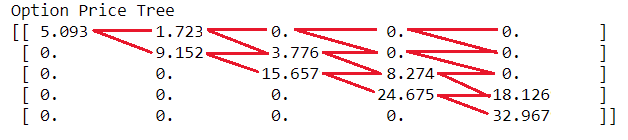

In [10]:
if N <= 5:    
    print('Option Price Tree')
    print(result[1])

In [11]:
if N <= 5:
    print('Stock Tree')
    print(result[0])

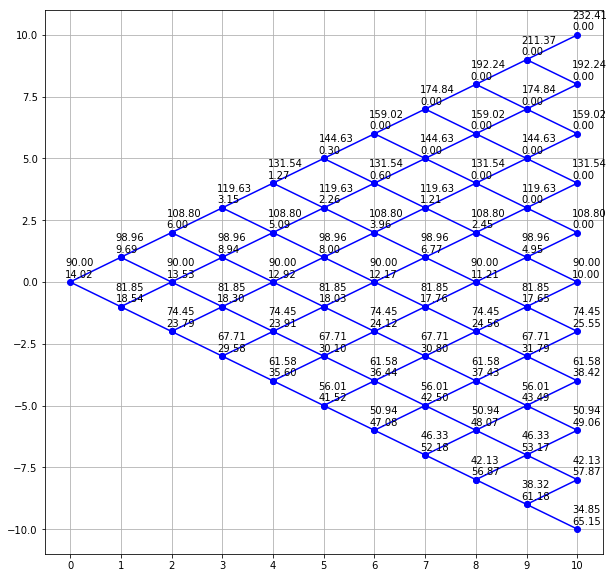

In [12]:
if N <= 20:
    m      = result[0]
    o      = result[1]
    labels = []
    for j in range(0,m.shape[0]):
        for i in range(0,j+1):
            labels.append(str("%.2f" % m[i,j]) + '\n' + str("%.2f" % o[i,j]))

    binomial_tree(N, labels)        

### Convergence Rate ###

When using binomial trees, errors may occur if only a few periods are used. This is
because a binomial tree will only produce one more leaf node (or potential outcome) than the
number of periods used, when infinite outcomes are actually possible. By increasing the number
of periods, we create more possible outcomes that are distributed more continuously.

In [13]:
nn         = range(10,1000,5)
opt_bs     = BlackScholes(-1, S0, K, r, 0.0, sigma, T)
price_bs   = [opt_bs for S in nn]
price_tree = []
for k in nn:
    sys.stdout.write("\r" + 'iter nr : ' + str(k))
    sys.stdout.flush()
    price_tree.append(binomial_model_european(k, S0, sigma, r, K, T)[1][0][0])

iter nr : 995

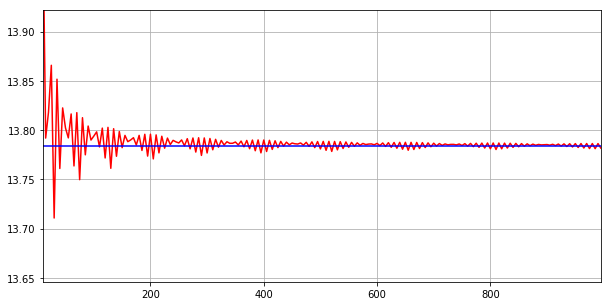

In [14]:
%matplotlib inline

fig = pl.figure(figsize=[10, 5])

pl.xlim(min(nn),max(nn))
pl.ylim(.99 * opt_bs, 1.01 * opt_bs)
pl.plot(nn, price_tree, color='r')
pl.plot(nn, price_bs,   color='b')
pl.grid()
pl.show()


### American Options ###

The method used to evaluate an American style derivative is very similar to that for the European option except that it is necessary to incorporate the early exercise feature. In the case of American options the value of the option at any node in the binomial tree is the greater between the value calculated by backward induction (the **continuation value**) and the payoff from early exercise. Specifically at time $t$ and node $i$ 

\begin{equation}
c_t^i = max \left[ 
max \left(K - S_t^i,o \right),  
e^{-rt}\left(p c_{t+1}^u + (1-p)c^d_{t+1}\right) 
\right]
\end{equation}

This is repeated until you return to the final node at the present time. This final node is the price of your options contract.

In [15]:
def binomial_model_american(N, S0, sigma, r, K, Maturity, opt_type = 'put'):
    """
    N      = number of binomial iterations
    S0     = initial stock price
    sigma  = factor change of upstate
    r      = risk free interest rate per annum
    K      = strike price
    """
    delta_t     = Maturity/float(N)
    discount    = exp(-r*delta_t)
    u           = exp(sigma*sqrt(delta_t))
    d           = 1 / u
    p           = (exp(r*delta_t)- d) / (u - d)
    q           = 1 - p

    # make stock price tree
    stock = np.zeros([N + 1, N + 1])
    for i in range(N + 1):
        for j in range(i + 1):
            stock[j, i] = S0 * (u ** (i - j)) * (d ** j)

    # Generate option prices recursively
    option = np.zeros([N + 1, N + 1])
    if opt_type  == 'put':
        option[:, N] = np.maximum(np.zeros(N + 1), (K - stock[:, N]))
    else:
        option[:, N] = np.maximum(np.zeros(N + 1), (stock[:, N]) - K)
        
    for i in range(N - 1, -1, -1):
        for j in range(0, i + 1):
            option[j, i] = (
                discount * (p * option[j, i + 1] + q * option[j + 1, i + 1])
            )
            #
            # dealing with early exercise
            #
            if opt_type == 'put':
                exercise     = np.maximum(0, K - stock[j, i])  
            else:
                exercise     = np.maximum(0, stock[j, i] - K)
                
            option[j, i] = np.maximum(exercise, option[j, i])

    return [stock, option]

In [33]:
result = binomial_model_american(N, S0, sigma, r, K, T, 'put')

print('Option price (binomial tree): ', result[1][0][0])

opt_bs = BlackScholes('P', S0, K, r, 0, sigma, T)
print('Option price (analytic)     : ', opt_bs)

('Option price (binomial tree): ', 11.784615830697945)
('Option price (analytic)     : ', 10.841383007448584)


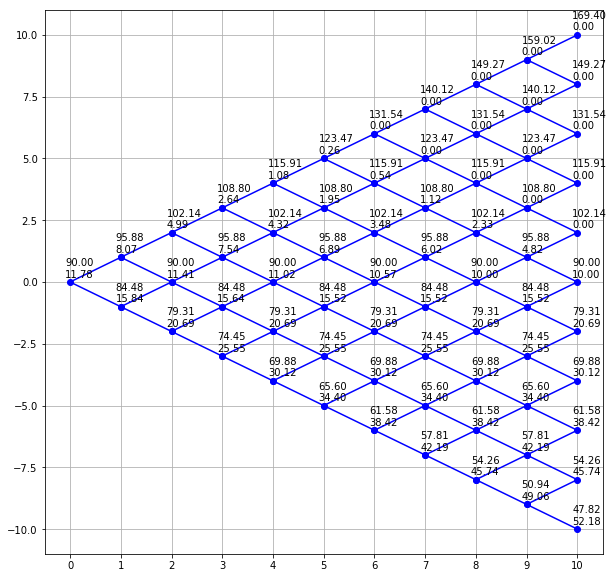

In [34]:
if N <= 20:
    m      = result[0]
    o      = result[1]
    labels = []
    for j in range(0,m.shape[0]):
        for i in range(0,j+1):
            labels.append(str("%.2f" % m[i,j]) + '\n' + str("%.2f" % o[i,j]))

    binomial_tree(N, labels)     

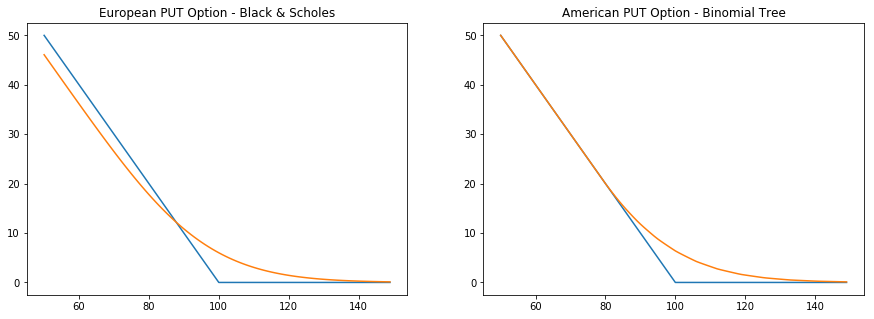

In [35]:
K     = 100.0   # strike price
T     =   1     # time-to-maturity
r     =   0.04  # short rate
sigma =   0.20  # volatility
delta =   0.0   # dividend yield

S      = np.arange(50, 150, 1.0)
PE     = BlackScholes(-1, S, K, r, delta, sigma, T)
PA     = [binomial_model_american(50, s, sigma, r, K, T)[1][0][0] for s in S]
payP   = np.maximum(K-S,0)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('European PUT Option - Black & Scholes')
plt.plot(S,payP)
plt.plot(S,PE)

plt.subplot(122)
plt.title('American PUT Option - Binomial Tree')
plt.plot(S,payP)
plt.plot(S,PA)


In [36]:
opt_fd = finite_difference_explicit('put', S0, K, sigma, T, True)

In [40]:
nn     = range(10,1000,10)
plt_bs = np.array([opt_bs for k in nn])
plt_fd = np.array([opt_fd for k in nn])

In [41]:
price_tree = []
for k in nn:
    sys.stdout.write("\r" + 'iter nr : ' + str(k))
    sys.stdout.flush()
    price_tree.append(binomial_model_american(k, S0, sigma, r, K, T)[1][0][0])

iter nr : 990

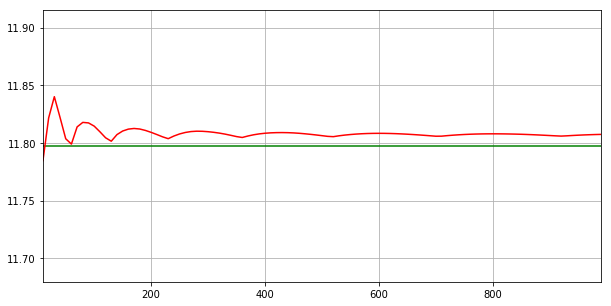

In [42]:
fig = pl.figure(figsize=[10, 5])

pl.xlim(min(nn),max(nn))
pl.ylim(.99 * plt_fd[0], 1.01 * plt_fd[0])
pl.plot(nn, plt_bs,     color='b')
pl.plot(nn, plt_fd,     color='g')
pl.plot(nn, price_tree, color='r')
pl.grid()
pl.show()

# References #

*Paul Wilmott*, **Derivatives, The Theory and Practice of Financial Engineering**, University Edition

*Paul Wilmott, Sam Howison and Jeff Dewinne*, **The Mathematics of Financial Derivatives, A Student Introduction**, Cambridge University Press

*John C. Hull*, **Option, Futures and Other Derivatives**, 6th Edition, Prentice Hall
